In [1]:
!pip install PyDrive

from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks/GAN"

    100% |████████████████████████████████| 993kB 26.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
celeba	 dcgan-G	DCGAN_v1.ipynb	wgp_dcgan-D  wgp_dcgan_samples
dcgan-D  dcgan_samples	svhn		wgp_dcgan-G


In [2]:
!ls "/content"

drive  sample_data


In [3]:
%matplotlib inline

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import dataset


# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [0]:
dataroot = "/content/drive/My Drive/Colab Notebooks/GAN/svhn/"

workers = 4

batch_size = 64

image_size = 32

channels = 3
z_dim = 100

num_epochs = 50

lr = 0.0002

beta1 = 0.5

In [10]:
datapath = '/content/drive/My Drive/Colab Notebooks/GAN/svhn'

image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5),
                         (.5, .5, .5))
])


def get_data_loader(dataset_location, batch_size):
    trainvalid = dset.SVHN(
        dataset_location, split='train',
        download=True,
        transform=image_transform
    )

    trainset_size = int(len(trainvalid) * 0.9)
    trainset, validset = dataset.random_split(
        trainvalid,
        [trainset_size, len(trainvalid) - trainset_size]
    )

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=workers
    )

    validloader = torch.utils.data.DataLoader(
        validset,
        batch_size=batch_size,
    )

    testloader = torch.utils.data.DataLoader(
            dset.SVHN(
            dataset_location, split='test',
            download=True,
            transform=image_transform
        ),
        batch_size=batch_size,
    )

    return trainloader, validloader, testloader

trainloader, validloader, testloader = get_data_loader(datapath, batch_size)


# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


Using downloaded and verified file: /content/drive/My Drive/Colab Notebooks/GAN/svhn/train_32x32.mat
Using downloaded and verified file: /content/drive/My Drive/Colab Notebooks/GAN/svhn/test_32x32.mat


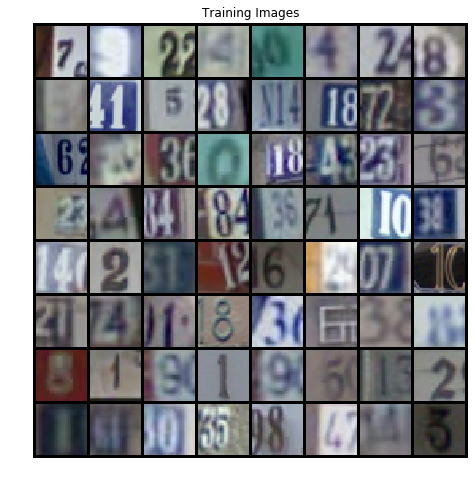

In [11]:
# Plot some training images
real_batch = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:batch_size], padding=2, normalize=True),(1,2,0)))

### DCGAN adapted from :
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#generative-adversarial-networks


# DCGAN

In [0]:
def dcgan_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Norm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Generator(nn.Module):

    def __init__(self, f=32):
        super(Generator, self).__init__()

        # base depth nb of feature maps
        self.f = f

        def dc_block(in_size, out_size, k=4, s=2, p=1):
            return nn.Sequential(
                nn.ConvTranspose2d(in_size, out_size, k, s, p, bias=False),
                nn.BatchNorm2d(out_size),
                nn.ReLU(True))

        self.main = nn.Sequential(
            dc_block(100, self.f * 8, 2, 1, 0),
            dc_block(self.f * 8, self.f * 4),
            dc_block(self.f * 4, self.f * 2),
            dc_block(self.f * 2, self.f),
            nn.ConvTranspose2d(self.f, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )


    def forward(self, z):
        return self.main(z)

In [14]:
from torchsummary import summary

# Create the generator
gan_G = Generator().to(device)


# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
gan_G.apply(dcgan_init)

noise = torch.randn(batch_size, z_dim, 1, 1, device=device)

# Print the model
print(gan_G)
summary(gan_G, (100,1,1))

Generator(
  (main): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 256, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (4): Con

In [0]:
class Discriminator(nn.Module):
    def __init__(self, f=32):
        super(Discriminator, self).__init__()

        # base nb of feature maps
        self.f = f

        def conv_block(in_size, out_size, k=4, s=2, p=1):
            return nn.Sequential(
                nn.Conv2d(in_size, out_size, k, s, p, bias=False),
                nn.BatchNorm2d(out_size),  # No batch norm for WGAN-GP
                nn.LeakyReLU(0.2, inplace=True))

        self.main = nn.Sequential(
            nn.Conv2d(channels, self.f, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            conv_block(self.f, self.f * 2),
            conv_block(self.f * 2, self.f * 4),
            conv_block(self.f * 4, self.f * 8),

            nn.Conv2d(self.f * 8, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()  # Remove Sigmoid for WGAN-GP objective
        )

    def forward(self, x):
        return self.main(x)

In [16]:
gan_D = Discriminator().to(device)

    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
gan_D.apply(dcgan_init)

# Print the model
print(gan_D)
summary(gan_D, (channels,image_size,image_size))

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (5): Conv2d(256, 1, kernel_size=(2, 2), stride=(1

In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(gan_D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(gan_G.parameters(), lr=lr, betas=(beta1, 0.999))

In [0]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(trainloader, 0):
        
        ## Discriminator
        gan_D.zero_grad()
        
        # real
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = gan_D(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # fake
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        fake = gan_G(noise)
        label.fill_(fake_label)
        output = gan_D(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ## Generator
        gan_G.zero_grad()
        label.fill_(real_label)
        output = gan_D(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        # Output training stats
        if i % 100 == 0:
            print('[%2d/%2d][%4d/%4d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        iters += 1
    
    # saving fixed sample images
    with torch.no_grad():
      fake = gan_G(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(trainloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

#### Saving Model

In [0]:
"""" SAVING STATES ""
G_filename = '/content/drive/My Drive/Colab Notebooks/GAN/dcgan-G'

torch.save(gan_G.state_dict(), G_filename)

D_filename = '/content/drive/My Drive/Colab Notebooks/GAN/dcgan-D'

torch.save(gan_D.state_dict(), D_filename)


In [0]:
import os

def save_samples(dir):
    G =  Generator().to(device)
    G.load_state_dict(torch.load(G_filename))
    G.eval()
    
    for p in G.parameters():
        p.requires_grad = False

    for i in range(10):
        print(i)
        noise = torch.randn(100, z_dim, 1, 1, device=device)
        images = G(noise)
        os.makedirs(f"{dir}/img/", exist_ok=True)
        for j, image in enumerate(images):
            filename = f"{dir}/img/{i * 100 + j:03d}.png"
            vutils.save_image(image, filename, normalize=True)

In [0]:
dcgan_samples = '/content/drive/My Drive/Colab Notebooks/GAN/dcgan_samples'

save_samples(dcgan_samples)


In [0]:
!ls '/content/drive/My Drive/Colab Notebooks/GAN/dcgan_samples/img'